# Introduction
In this notebook we generate plots to evaluate our Input and ChIP samples using output from ChIPQC v1.26.0

# Set Environment
Import the libaries need to handle html formats and data tables

In [1]:
from bs4 import BeautifulSoup # used to parse HTML
import pandas as pd # used to handle dataframes/tables
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

the code below is used to parse tables in html

In [2]:
class HTMLTableParser:
       
        def parse_url(self, url):
            soup = BeautifulSoup(url, 'lxml')
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]  
    
        def parse_html_table(self, table):
            n_columns = 0
            n_rows=0
            column_names = []
    
            # Find number of rows and columns
            # we also find the column titles if we can
            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')
                if len(td_tags) > 0:
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0:
                    for th in th_tags:
                        column_names.append(th.get_text().strip())
    
            # Safeguard on Column Titles
            if len(column_names) > 0 and len(column_names) != n_columns:
                raise Exception("Column titles do not match the number of columns")
    
            columns = column_names if len(column_names) > 0 else range(0,n_columns)
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            row_marker = 0
            for row in table.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    df.iat[row_marker,column_marker] = column.get_text().strip()
                    column_marker += 1
                if len(columns) > 0:
                    row_marker += 1
                    
            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass
            
            return df

hard-code the location of the ChIPQC results within the Github repo

In [3]:
indir="../data/ChIPQCreport"

# Summary Tables

## Input-Seq (20 Random Inputs)

In [4]:
input_names=["noMask","GS","BL"]
input_dir=["20inputs_noMask",
              "20inputs_gsMask",
              "20inputs_blMask"]
input_summary_df=None
for i in range(0,len(input_names)):
    iname = input_names[i]
    ichipqc = ("%s/%s/ChIPQC.html" % (indir,input_dir[i]))
    hp = HTMLTableParser()
    with open(ichipqc, 'r') as f:

        contents = f.read()

        soup = BeautifulSoup(contents, "html.parser")

        i_summary_table = soup.find_all('table')[0]
        i_summary_df = hp.parse_html_table(i_summary_table)
        i_summary_df["mask"]=iname
        if i == 0:
            input_summary_df = i_summary_df.copy()
        else:
            input_summary_df = input_summary_df.append(
                i_summary_df, ignore_index=True)

### SSD boxplot

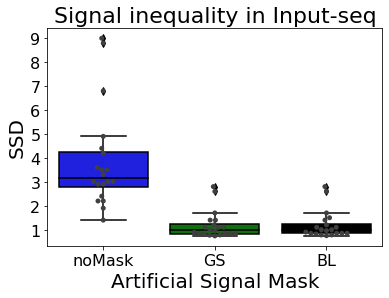

In [5]:
# generate boxplot
ax = sns.boxplot(x="mask", y="SSD", 
                 palette=sns.color_palette(["blue","green","black"]),
                 data=input_summary_df)
# use swarmplot() to show the data points on top of the box plots
ax = sns.swarmplot(x="mask", y="SSD", data=input_summary_df, color=".25")
# label each integer on the y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# set title and x label
ax.set_title('Signal inequality in Input-seq',fontsize=22)
ax.set_xlabel('Artificial Signal Mask',fontsize=20)
ax.set_ylabel('SSD',fontsize=20)
ax.tick_params(labelsize=16)

## ChIP-Seq (LFY, FD, and TFL1)

In [7]:
mask_list=["noMask","gsMask","blMask"]
mask_dic={"noMask":"noMask", 
         "gsMask":"GS",
         "blMask":"BL"}
dup_list=["wiDups","noDups"]
macs2_controls_list=["noControl","lfyWInputControl",
              "tfl1WInputControl",
               "respectiveMockControls"]

all_chip_summary_df=None
i=0
for mask in mask_list:
    for dup in dup_list:
        for mcontrol in macs2_controls_list:
            if (mcontrol == "lfyWInputControl" or
                mcontrol == "tfl1WInputControl" or
                dup == "wiDups"):
                subdir=("chip_%s_%s_%s_extFragSize_qval10" % 
                        (mask, dup, mcontrol))
                chipqc_html = ("%s/%s/ChIPQC.html" % (indir,subdir))
                hp = HTMLTableParser()
                with open(chipqc_html, 'r') as f:
                    contents = f.read()
                    soup = BeautifulSoup(contents, "html.parser")

                    chip_summary_table = soup.find_all('table')[0]
                    chip_summary_df = hp.parse_html_table(chip_summary_table)
                    chip_summary_df["mask"]=mask_dic[mask]
                    chip_summary_df["dup"]=dup
                    chip_summary_df["macs2_control"]=mcontrol
                    if i == 0:
                        all_chip_summary_df = chip_summary_df.copy()
                    else:
                        all_chip_summary_df = all_chip_summary_df.append(
                            chip_summary_df, ignore_index=True)
                i+=1

In [10]:
TFL1_A_W_chipSummary_df = (
    all_chip_summary_df.loc[((all_chip_summary_df["ID"].str.contains("TFL1_A_W")) &
                         (all_chip_summary_df["macs2_control"]=="tfl1WInputControl")),:])

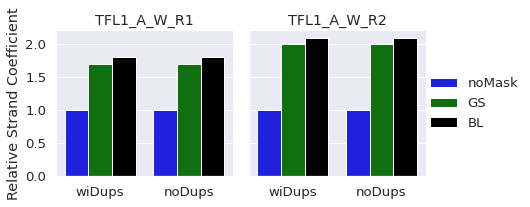

In [11]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(TFL1_A_W_chipSummary_df, col="ID")
g.map_dataframe(sns.barplot, x="dup", y="RelCC", 
                hue="mask",
                palette=sns.color_palette(["blue","green","black"]))
g.set_axis_labels("", "Relative Strand Coefficient")
g.set_titles(col_template="{col_name}")
g.add_legend()